In [1]:
import cv2
import numpy as np

# Load image
img = cv2.imread('plant.jpg')

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_green = np.array([35, 100, 50])
upper_green = np.array([85, 255, 255])

mask = cv2.inRange(hsv, lower_green, upper_green)
leaf_only = cv2.bitwise_and(img, img, mask=mask)


pixel_area = cv2.countNonZero(mask)

conversion_factor = 100  # pixels per cm²
area_cm2 = pixel_area / conversion_factor

print(f"Leaf area: {area_cm2:.2f} cm²")


cv2.imwrite('leaf_segmented.jpg', leaf_only)


cv2.namedWindow('Original Image', cv2.WINDOW_NORMAL)
cv2.namedWindow('Leaf Only', cv2.WINDOW_NORMAL)
cv2.namedWindow('Mask', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Original Image', 400, 300)
cv2.resizeWindow('Leaf Only', 400, 300)
cv2.resizeWindow('Mask', 400, 300)




cv2.imshow('Original Image', img)
cv2.imshow('Leaf Only', leaf_only)
cv2.imshow('Mask', mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

Leaf area: 16081.81 cm²


In [5]:
import cv2
import numpy as np


left_img = cv2.imread('plant1.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('plant2.jpg', cv2.IMREAD_GRAYSCALE)

In [21]:
# Example values — replace with your real calibration data
focal_length = 3845  # in pixels
baseline = 0.2      # in meters (e.g., 10 cm between cameras)



stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16*6,  # must be divisible by 16
    blockSize=5,
    P1=8 * 3 * 5 ** 2,
    P2=32 * 3 * 5 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0


In [22]:
depth = np.zeros(disparity.shape, dtype=np.float32)
depth[disparity > 0] = (focal_length * baseline) / disparity[disparity > 0]


depth_display = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
depth_display = np.uint8(depth_display)

cv2.namedWindow('Depth Map', cv2.WINDOW_NORMAL)
cv2.resizeWindow('Depth Map', 400, 300)
cv2.imshow('Depth Map', depth_display)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [27]:
# Mask out background using thresholding (you can improve this with segmentation)
plant_mask = depth < 10  # Keep only plausible depth range

# Get the minimum and maximum Y coordinates (in image pixels)
plant_pixels = np.column_stack(np.where(plant_mask))

if len(plant_pixels) > 0:
    top_y = np.min(plant_pixels[:, 0])
    bottom_y = np.max(plant_pixels[:, 0])
    height_pixels = bottom_y - top_y

    # Convert pixel height to meters (requires camera intrinsics or scale reference)
    # You can estimate height from difference in depth values if camera is front-facing:
    plant_depth_values = depth[plant_mask]
    height_meters = np.max(plant_depth_values) - np.min(plant_depth_values)

    print(f"Estimated Plant Height: {height_meters:.2f} meters")
else:
    print("Plant not detected.")


Estimated Plant Height: 10.00 meters


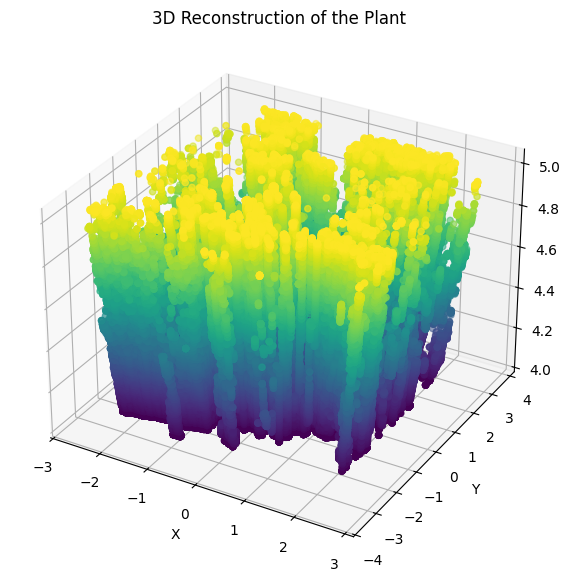

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load images
left_img = cv2.imread('plant1.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('plant2.jpg', cv2.IMREAD_GRAYSCALE)

# Calibration parameters
focal_length = 3845  # in pixels (assumed)
baseline = 0.1       # in meters (e.g., 10 cm between cameras)

# Stereo SGBM setup
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=16 * 6,  # must be divisible by 16
    blockSize=5,
    P1=8 * 3 * 5 ** 2,
    P2=32 * 3 * 5 ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

# Compute disparity map
disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0

# Depth map calculation
depth = np.zeros(disparity.shape, dtype=np.float32)
depth[disparity > 0] = (focal_length * baseline) / disparity[disparity > 0]

# Mask out background
plant_mask = (depth > 0) & (depth < 5.0)  # Keep only plausible depth range

# Get the coordinates of plant pixels
plant_pixels = np.column_stack(np.where(plant_mask))

# Reconstruct 3D coordinates
# Assuming the camera's principal point is at the center of the image
h, w = depth.shape
cx, cy = w / 2, h / 2  # principal point (image center)

# Calculate 3D points
X = (plant_pixels[:, 1] - cx) * depth[plant_pixels[:, 0], plant_pixels[:, 1]] / focal_length
Y = (plant_pixels[:, 0] - cy) * depth[plant_pixels[:, 0], plant_pixels[:, 1]] / focal_length
Z = depth[plant_pixels[:, 0], plant_pixels[:, 1]]

# Plot 3D points
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, c=Z, cmap='viridis', marker='o')

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction of the Plant')

# Show the plot
plt.show()
